# Test Simulation Methods (Equity + Options)

This notebook demonstrates how to compute **Value-at-Risk (VaR)** and **Conditional Value-at-Risk (CVaR)**  
using two simulation-based approaches:

1. **Parametric Monte Carlo simulation**
2. **Historical simulation with bootstrapping**

We apply both methods to a portfolio containing:
- **Equity positions** (real stocks: MSFT, AAPL, NVDA)
- **Derivative positions** (European options on the same stocks)

The pricing of options is based on the **Black–Scholes formula**, and the simulations use both:
- **Realistic input data** fetched from Yahoo Finance
- **Volatility and risk-free rate assumptions** for each option

We compute:
- The **P&L distribution** of the portfolio after 1-day horizon
- The associated **VaR** and **CVaR** at a specified confidence level (e.g., 95%)
- And visualize the resulting distribution for risk analysis


In [4]:
import data_download as dd
import numpy as np
import simulations as sim_2
import matplotlib.pyplot as plt
import seaborn as sns
import plots as pt
import pandas as pd

# Form a portfolio and test Black-Scholes

In [5]:
# STEP 1 — Data Retrieval and Setup
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL",
    "JPM"
]

# Download prices
price_data = dd.get_raw_prices(tickers, start="2024-01-01")

# Convert prices to base currency
price_data_converted = dd.convert_to_base(price_data, base="CHF")

# Create portfolio
shares = pd.Series([10, 9, 80, 6, -9], index=tickers)

position_data = dd.create_portfolio(price_data_converted, shares)

# Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.summary_statistics(position_data)

# Values for the optiions
S0 = price_data_converted.iloc[-1]  # Use prices in CHF
volatility_annualized = returns.std() * np.sqrt(252)


[currency detection] AAPL: USD
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] MSFT: USD
[currency detection] NVDA: USD
[fx download] Downloading FX pairs: CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X


In [6]:
# STEP 2 — Define Option Contracts
options = [
    {
        "idx": tickers.index("AAPL"),
        "K": 200,
        "T": 40 / 252,
        "r": 0.015,
        "sigma": volatility_annualized["AAPL"],
        "type": "call",
        "qty": 1
    },
    {
        "idx": tickers.index("JPM"),
        "K": 290,
        "T": 30 / 252,
        "r": 0.015,
        "sigma": volatility_annualized["JPM"],
        "type": "put",
        "qty": 1
    },
    {
        "idx": tickers.index("NVDA"),
        "K": 100,
        "T": 60 / 252,
        "r": 0.015,
        "sigma": volatility_annualized["NVDA"],
        "type": "call",
        "qty": 1
    }
]


In [ ]:
# STEP 3 — Portfolio Valuation Display
print("\nEquity Positions (latest prices):")
total_eq_val = 0
for i, tkr in enumerate(tickers):
    value = shares.iloc[i] * S0[tkr]
    print(f"{tkr:5}: {shares.iloc[i]:2} shares × {S0[tkr]:.2f} = {value:.2f} CHF")
    total_eq_val += value

print("\nOption Values (Black-Scholes at time 0):")
total_opt_val = 0
for i, opt in enumerate(options):
    spot = S0[tickers[opt["idx"]]]
    price_bs = sim_2.black_scholes(spot, opt["K"], opt["T"], opt["r"], opt["sigma"], opt["type"])
    val = price_bs * opt["qty"]
    total_opt_val += val
    print(f"Option {i+1} on {tickers[opt['idx']]} ({opt['type']}): "
          f"BS = {price_bs:.2f} × {opt['qty']} = {val:.2f} CHF")

total_portfolio_val = total_eq_val + total_opt_val
print(f"\nTotal equity value:     {total_eq_val:.2f} CHF")
print(f"Total option value:     {total_opt_val:.2f} CHF")
print(f"Total portfolio value:  {total_portfolio_val:.2f} CHF")



Equity Positions (latest prices):
AAPL : 10 shares × 176.93 = 1769.30 USD
MSFT :  9 shares × 380.45 = 3424.06 USD
NVDA : 80 shares × 113.40 = 9071.80 USD
GOOGL:  6 shares × 139.18 = 835.10 USD
JPM  : -9 shares × 224.08 = -2016.73 USD

Option Values (Black-Scholes at time 0):
Option 1 on AAPL (call): BS = 2.08 × 1 = 2.08 USD
Option 2 on JPM (put): BS = 65.43 × 1 = 65.43 USD
Option 3 on NVDA (call): BS = 20.07 × 1 = 20.07 USD

Total equity value:     13083.53 USD
Total option value:     87.57 USD
Total portfolio value:  13171.10 USD


In [31]:
price_data.head()   

Ticker            AAPL       GOOGL         JPM        MSFT       NVDA
Date                                                                 
2024-01-02  184.290421  137.512558  166.179535  366.707367  48.149918
2024-01-03  182.910522  138.258987  165.455261  366.440430  47.551144
2024-01-04  180.587540  135.741028  166.553268  363.810272  47.979984
2024-01-05  179.862823  135.084167  167.388885  363.622406  49.078564
2024-01-08  184.210999  138.179367  167.145966  370.484528  52.233379

# Single day Monte Carlo Simulations


This simulation estimates 1-day **VaR** and **ES** using a parametric Monte Carlo approach.

#### Assumptions:

- Asset returns follow a **multivariate normal distribution**  
- One-step horizon of 1 trading day: $\Delta t = \frac{1}{252}$  
- Expected returns $\mu$ and covariance matrix $\Sigma$ estimated from historical data  
- The portfolio includes both linear (stocks) and nonlinear instruments (European options)

---

#### Simulation Steps:

1. Generate $N$ scenarios of daily returns:
   $$
   R_i \sim \mathcal{N}(\mu, \Sigma), \quad i = 1, \dots, N
   $$

2. Compute simulated asset prices:
   $$
   S_i = S_0 \cdot (1 + R_i)
   $$

3. For each scenario $i$, compute portfolio P&L including:
   - equity P&L from price differences  
   - option P&L from repricing via Black-Scholes:
     $$
     C(S_i, K, T - \Delta t, r, \sigma)
     $$

4. Construct the empirical distribution of P&L across all $N$ scenarios

5. Compute:

- **VaR** at level $\alpha$ (as a positive number):

  $$
  \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P\&L})
  $$

- **CVaR** (Expected Shortfall):

  $$
  \text{CVaR}_\alpha = -\mathbb{E}\left[\text{P\&L} \mid \text{P\&L} \leq \text{quantile}_\alpha(\text{P\&L})\right]
  $$

---

This approach captures the full distribution of outcomes including nonlinear payoffs, but only for a single-day shock.


In [32]:
confidence_level = 0.99

In [ ]:
# Run Parametric Monte Carlo VaR and ES (1-day, 99% level)
var_mc, pnl_mc = sim_2.monte_carlo_var(
    price_data=price_data_converted[tickers],  # ensure correct order
    shares=shares,
    options=options,
    confidence_level=confidence_level,
    simulations=10_000,
    seed=1
)

es_mc = sim_2.simulation_es(var_mc, pnl_mc)

# Display Monte Carlo Results
print(f"Monte Carlo VaR ({int(confidence_level * 100)}%):  {var_mc:,.2f} CHF")
print(f"Monte Carlo ES ({int(confidence_level * 100)}%):  {es_mc:,.2f} CHF")

Monte Carlo VaR (99%):  845.34 CHF
Monte Carlo ES (99%):  941.89 CHF



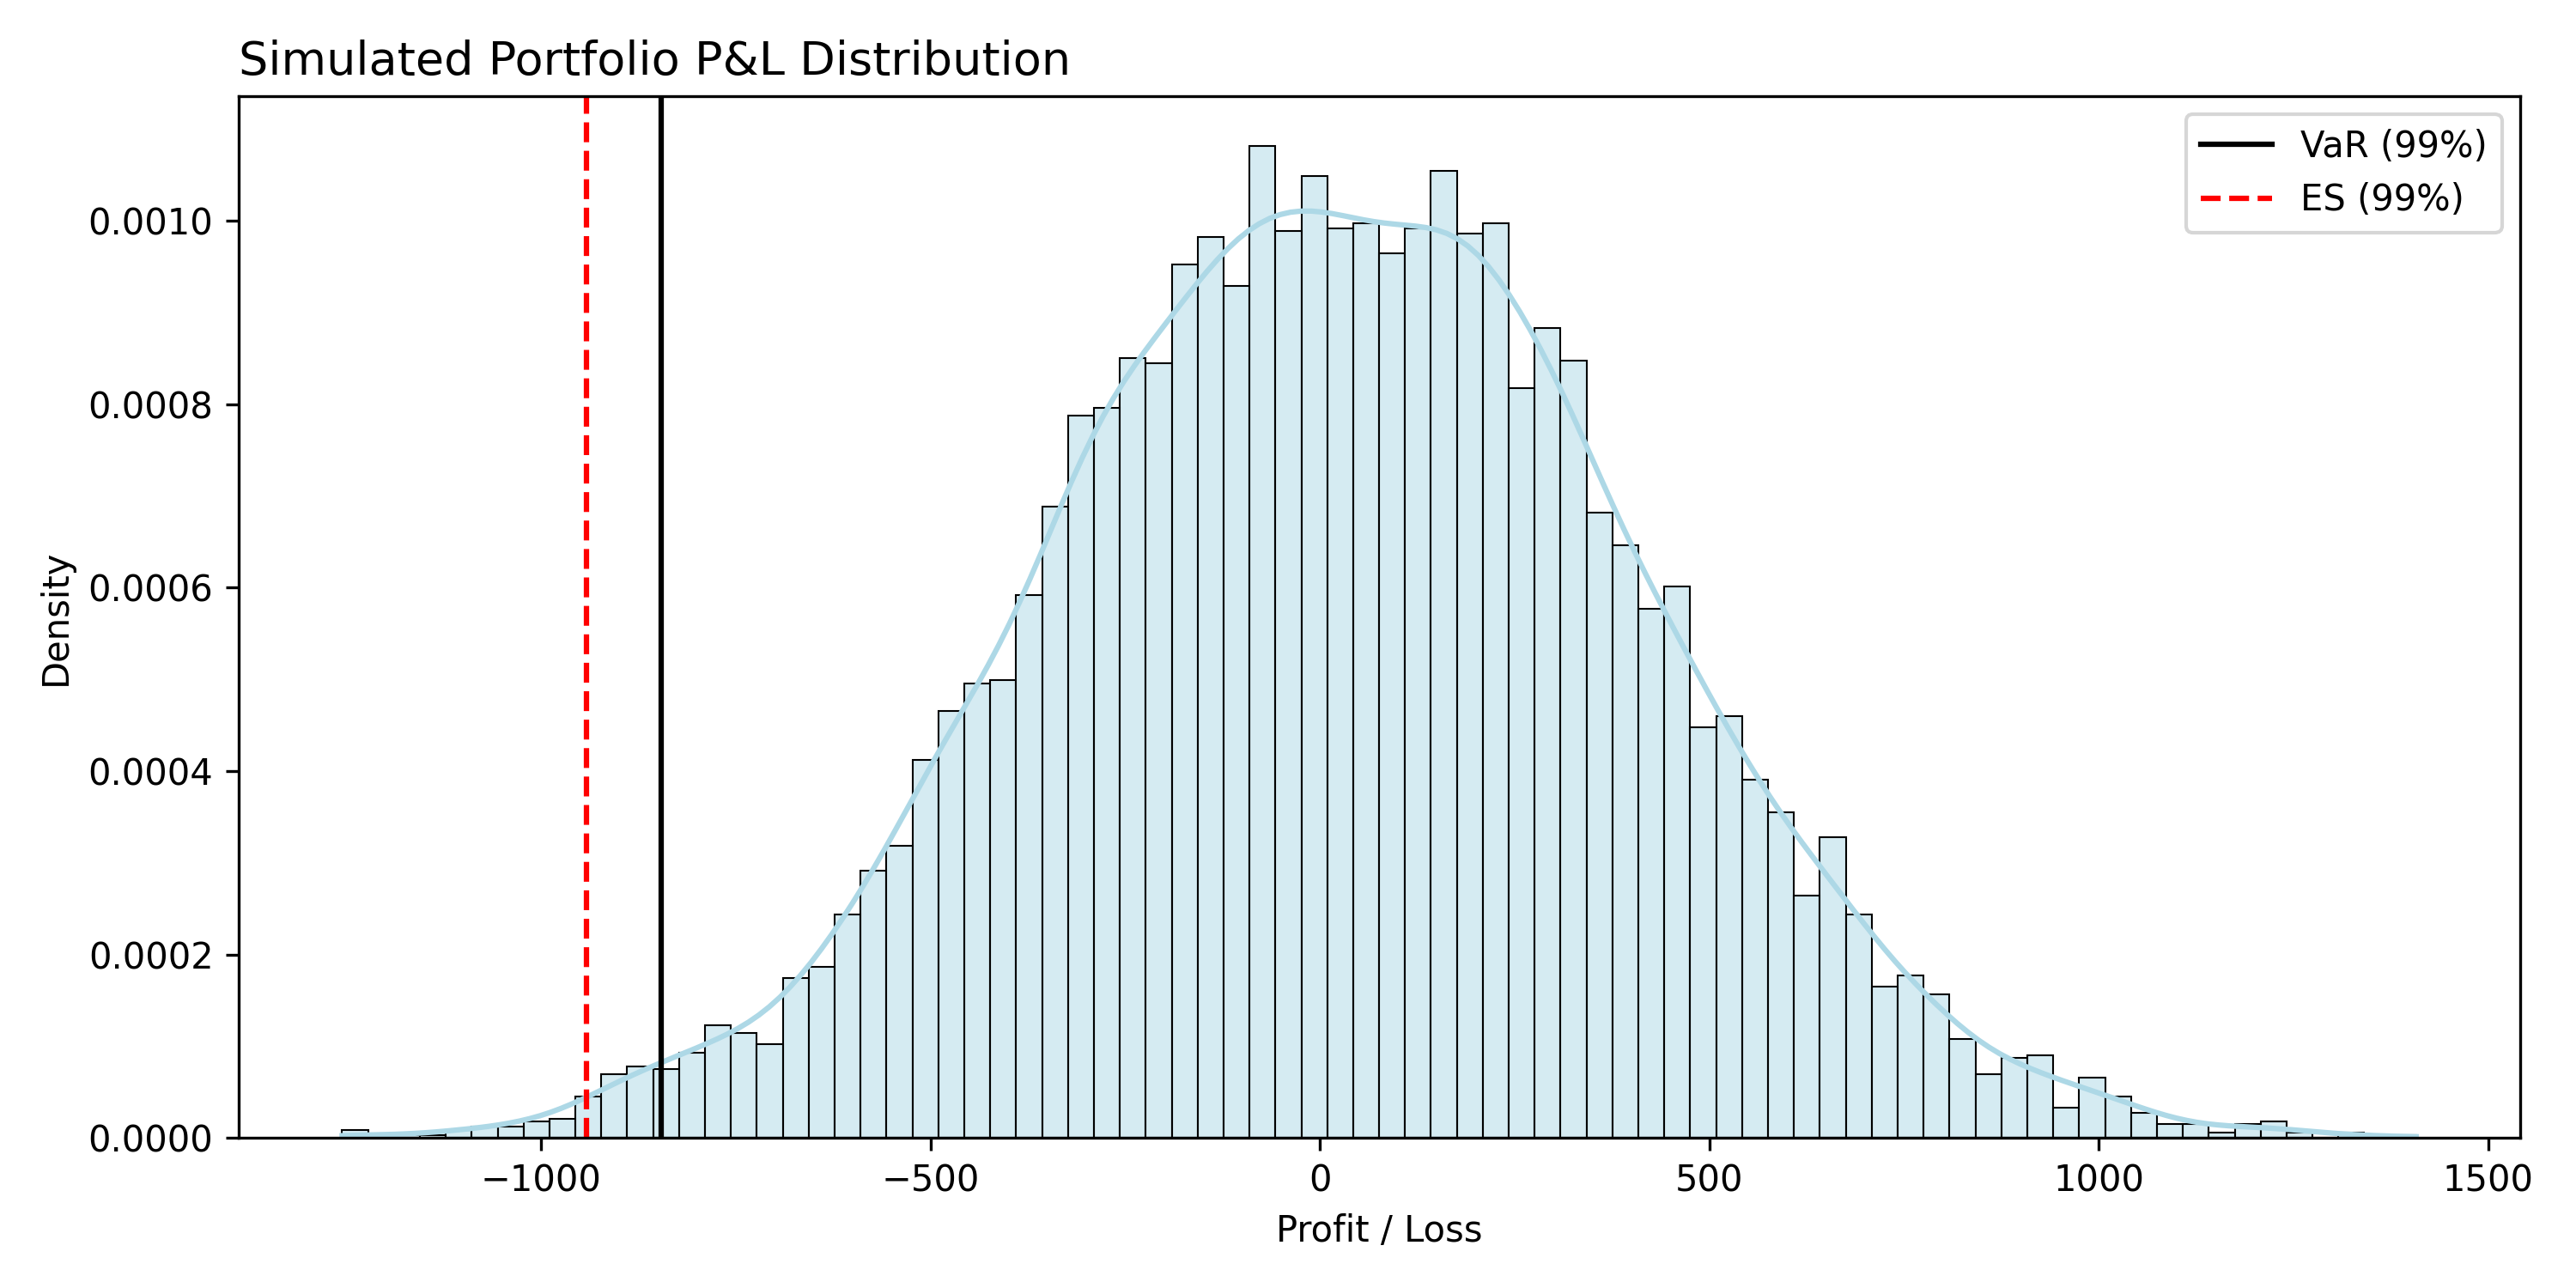

In [34]:
pt.plot_simulated_distribution(
    pnl=pnl_mc,
    var=var_mc,
    es=es_mc,
    confidence_level=0.99
)

# Multi-Day Montecarlo Simulation

Unlike the single-day approach, the multi-day simulation explicitly models the **evolution of asset prices over multiple days**.

---

#### Key Differences:

- The simulation runs over $T$ days instead of 1:

  $$
  S^{(i)}_{t+1} = S^{(i)}_t \cdot (1 + R^{(i)}_t), \quad R^{(i)}_t \sim \mathcal{N}(\mu, \Sigma)
  $$

- Correlated random returns are generated at each step using Cholesky decomposition:

  $$
  R_t = \mu + LZ_t, \quad Z_t \sim \mathcal{N}(0, I)
  $$

- Each path $i$ produces a full price trajectory:

  $$
  \{ S_0^{(i)}, S_1^{(i)}, \dots, S_T^{(i)} \}
  $$

- The portfolio value is computed at each step, and final profit/loss is:

  $$
  \text{P\&L}^{(i)} = V_T^{(i)} - V_0
  $$

- VaR and CVaR are estimated from the distribution of final P&L values across all $i = 1, \dots, N$:

  $$
  \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P\&L})
  $$

  $$
  \text{CVaR}_\alpha = -\mathbb{E}\left[\text{P\&L} \mid \text{P\&L} \leq \text{quantile}_\alpha(\text{P\&L})\right]
  $$

---

#### Remarks:

- This approach captures the **compounding** of returns and the **path-dependent risk** over time  
- It assumes parameters $(\mu, \Sigma)$ stay constant throughout the simulation horizon  
- Option repricing across time is possible but not included unless explicitly modeled


#### Remarks:

- This approach captures the **compounding** of returns and the **path-dependent risk** over time
- It assumes parameters ($\mu$, $\Sigma$) stay constant throughout the simulation horizon
- Option repricing across time is possible but not included unless explicitly modeled



In [35]:
# Run the simulation
var_mc100, pnl_mc100, portfolio_paths = sim_2.multiday_monte_carlo_var(
    price_data=price_data_converted,
    shares=shares.values,
    confidence_level=0.99,
    days_ahead=20,
    simulations=10_000,
)

es_mc = sim_2.simulation_es(var_mc100, pnl_mc100)

# Print results
print(f"Monte Carlo 100-day VaR (99%):  {var_mc100:,.2f} CHF")
print(f"Monte Carlo 100-day ES  (99%):  {es_mc:,.2f} CHF")


Monte Carlo 100-day VaR (99%):  2,880.87 CHF
Monte Carlo 100-day ES  (99%):  3,291.64 CHF



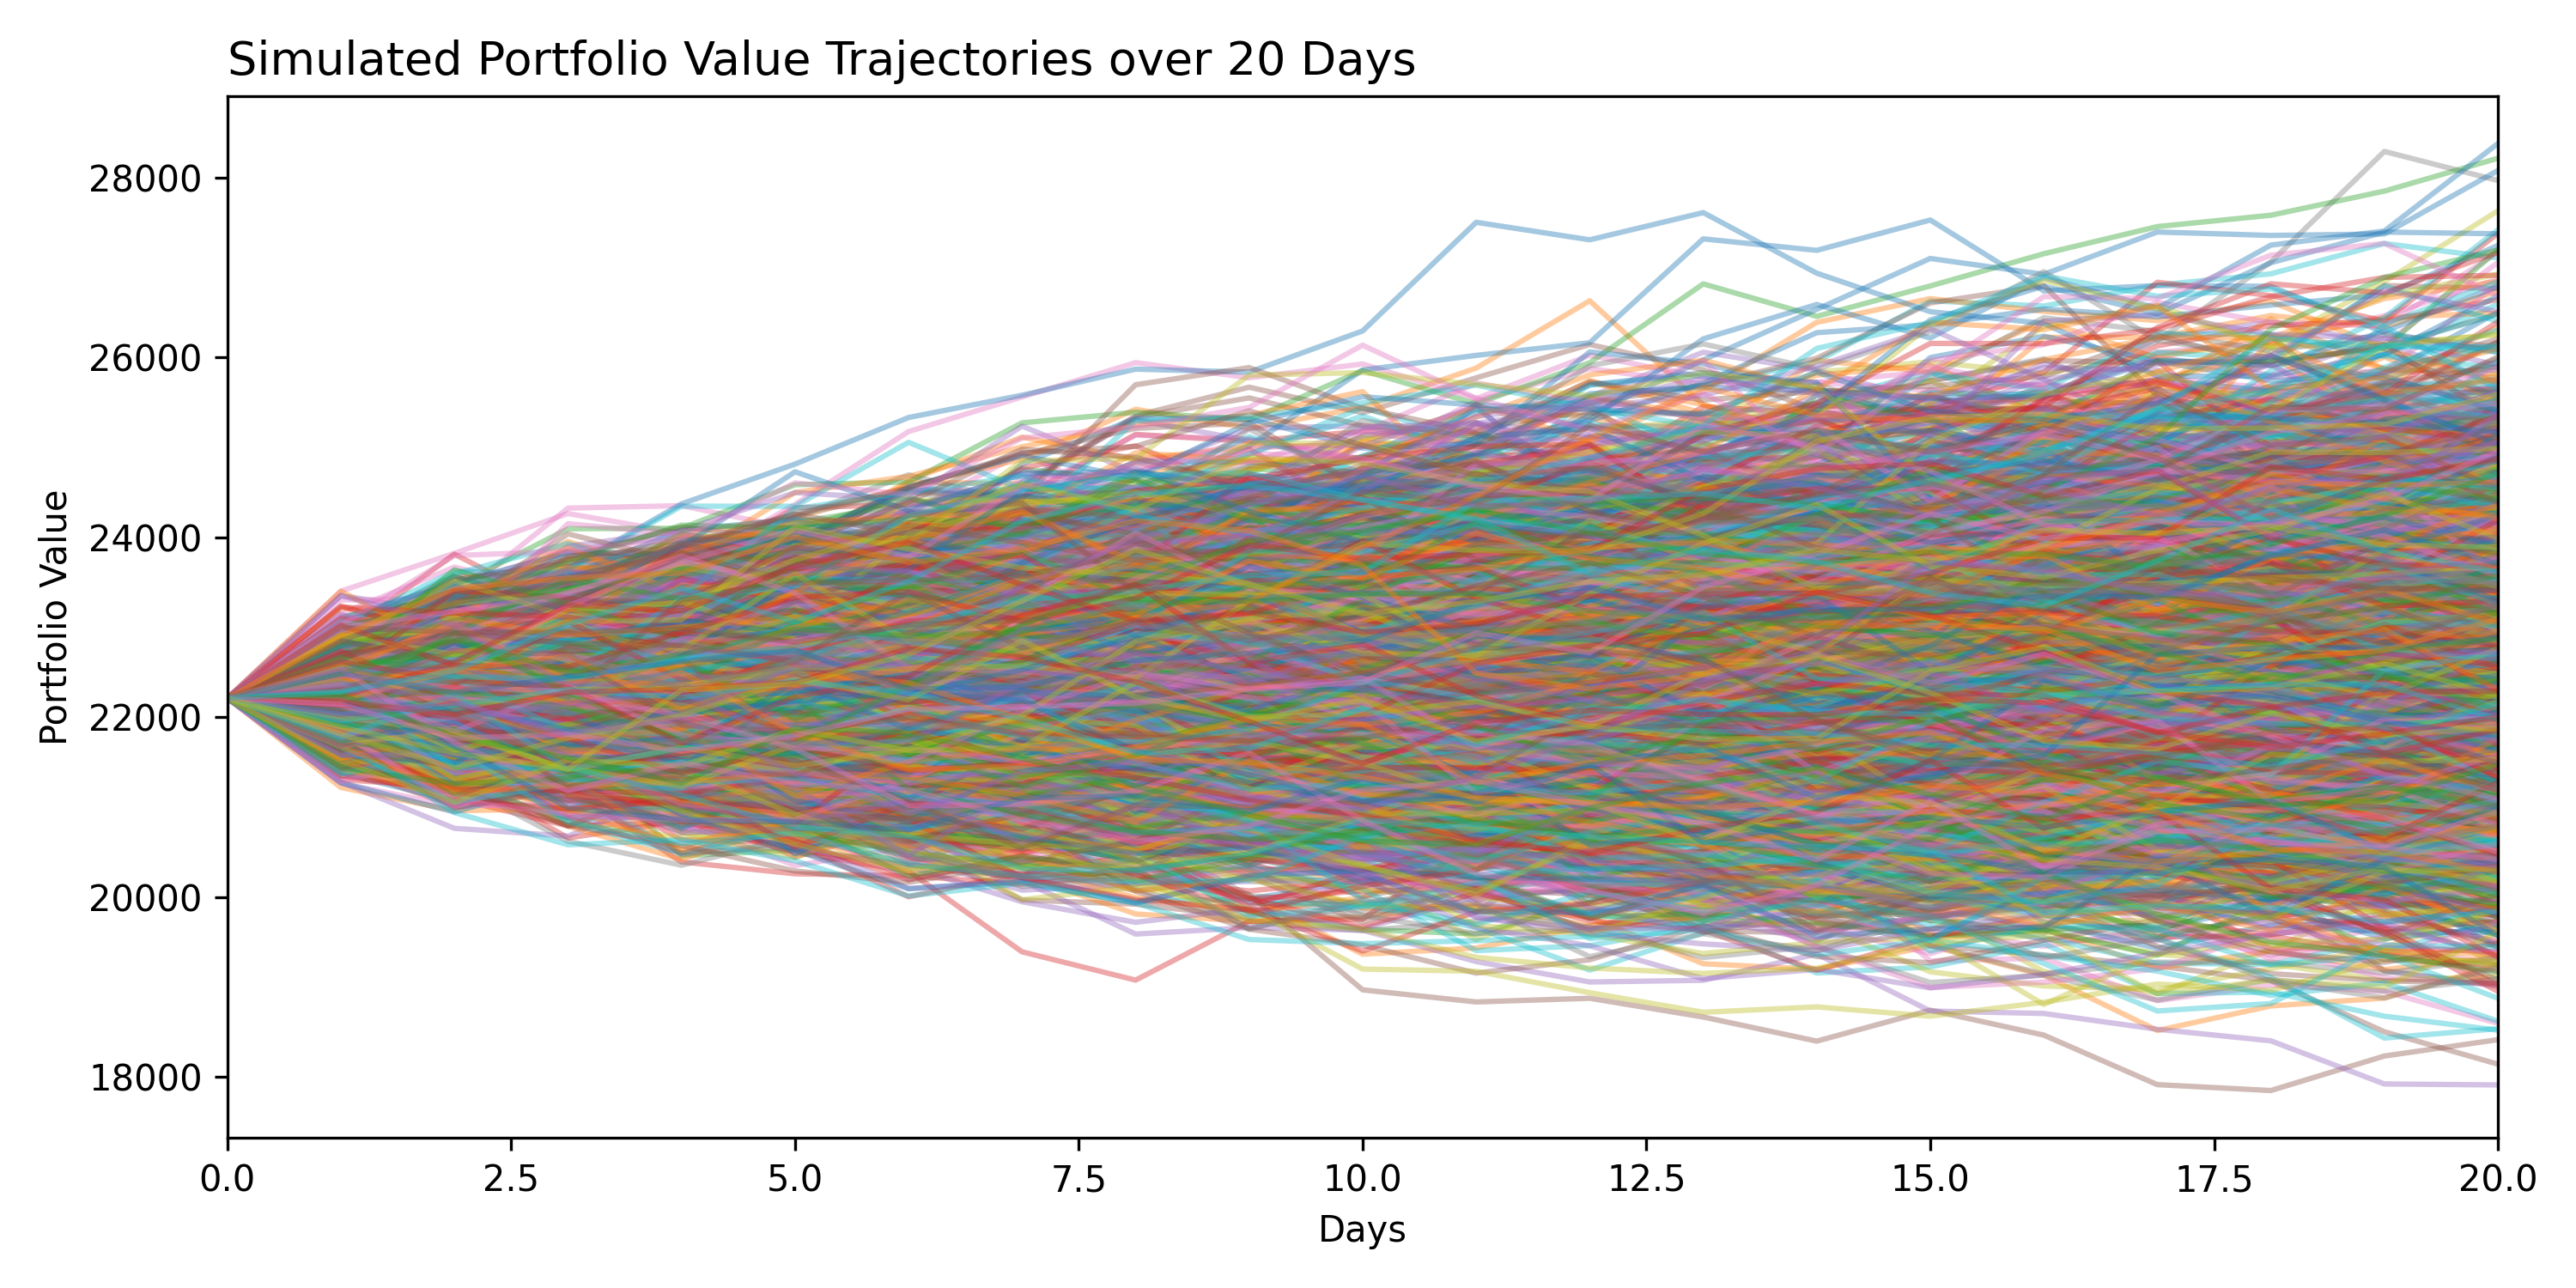

In [36]:
pt.plot_simulated_paths(portfolio_paths)

### Historical Simulation

Historical Simulation (HS) is a non-parametric approach that replays historical shocks to estimate risk.

---

#### Steps:

1. Take a matrix of historical returns:

   $$
   R_{\text{hist}} = \begin{bmatrix}
   r_{1,1} & r_{1,2} & \dots & r_{1,n} \\
   r_{2,1} & r_{2,2} & \dots & r_{2,n} \\
   \vdots  & \vdots  &       & \vdots \\
   r_{T,1} & r_{T,2} & \dots & r_{T,n}
   \end{bmatrix}
   $$

2. For each row $r_t$, simulate prices:

   $$
   S_t^{\text{sim}} = S_0 \cdot (1 + r_t)
   $$

3. Recompute portfolio value $V_t^{\text{sim}}$ under each scenario, including option repricing

4. Compute P&L:

   $$
   \text{P\&L}_t = V_t^{\text{sim}} - V_0
   $$

5. From the empirical distribution of P&L, compute:

   $$
   \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P\&L})
   $$

   $$
   \text{CVaR}_\alpha = - \mathbb{E}[\text{P\&L} \mid \text{P\&L} \leq \text{quantile}_\alpha(\text{P\&L})]
   $$

---

HS is very intuitive and data-driven, but completely relies on the historical return distribution.



In [37]:
# Run historical simulation (1-day horizon, 99% confidence)
var_hist, pnl_hist = sim_2.historical_simulation_var(
    price_data=price_data_converted,
    shares=shares.values,
    options=options,
    confidence_level=0.99,
)

es_hist = sim_2.simulation_es(var_hist, pnl_hist)

# Display results
print(f"Historical Simulation VaR (99%):   {var_hist:,.2f} CHF")
print(f"Historical Simulation ES  (99%):   {es_hist:,.2f} CHF")


Historical Simulation VaR (99%):   1,013.39 CHF
Historical Simulation ES  (99%):   1,464.24 CHF



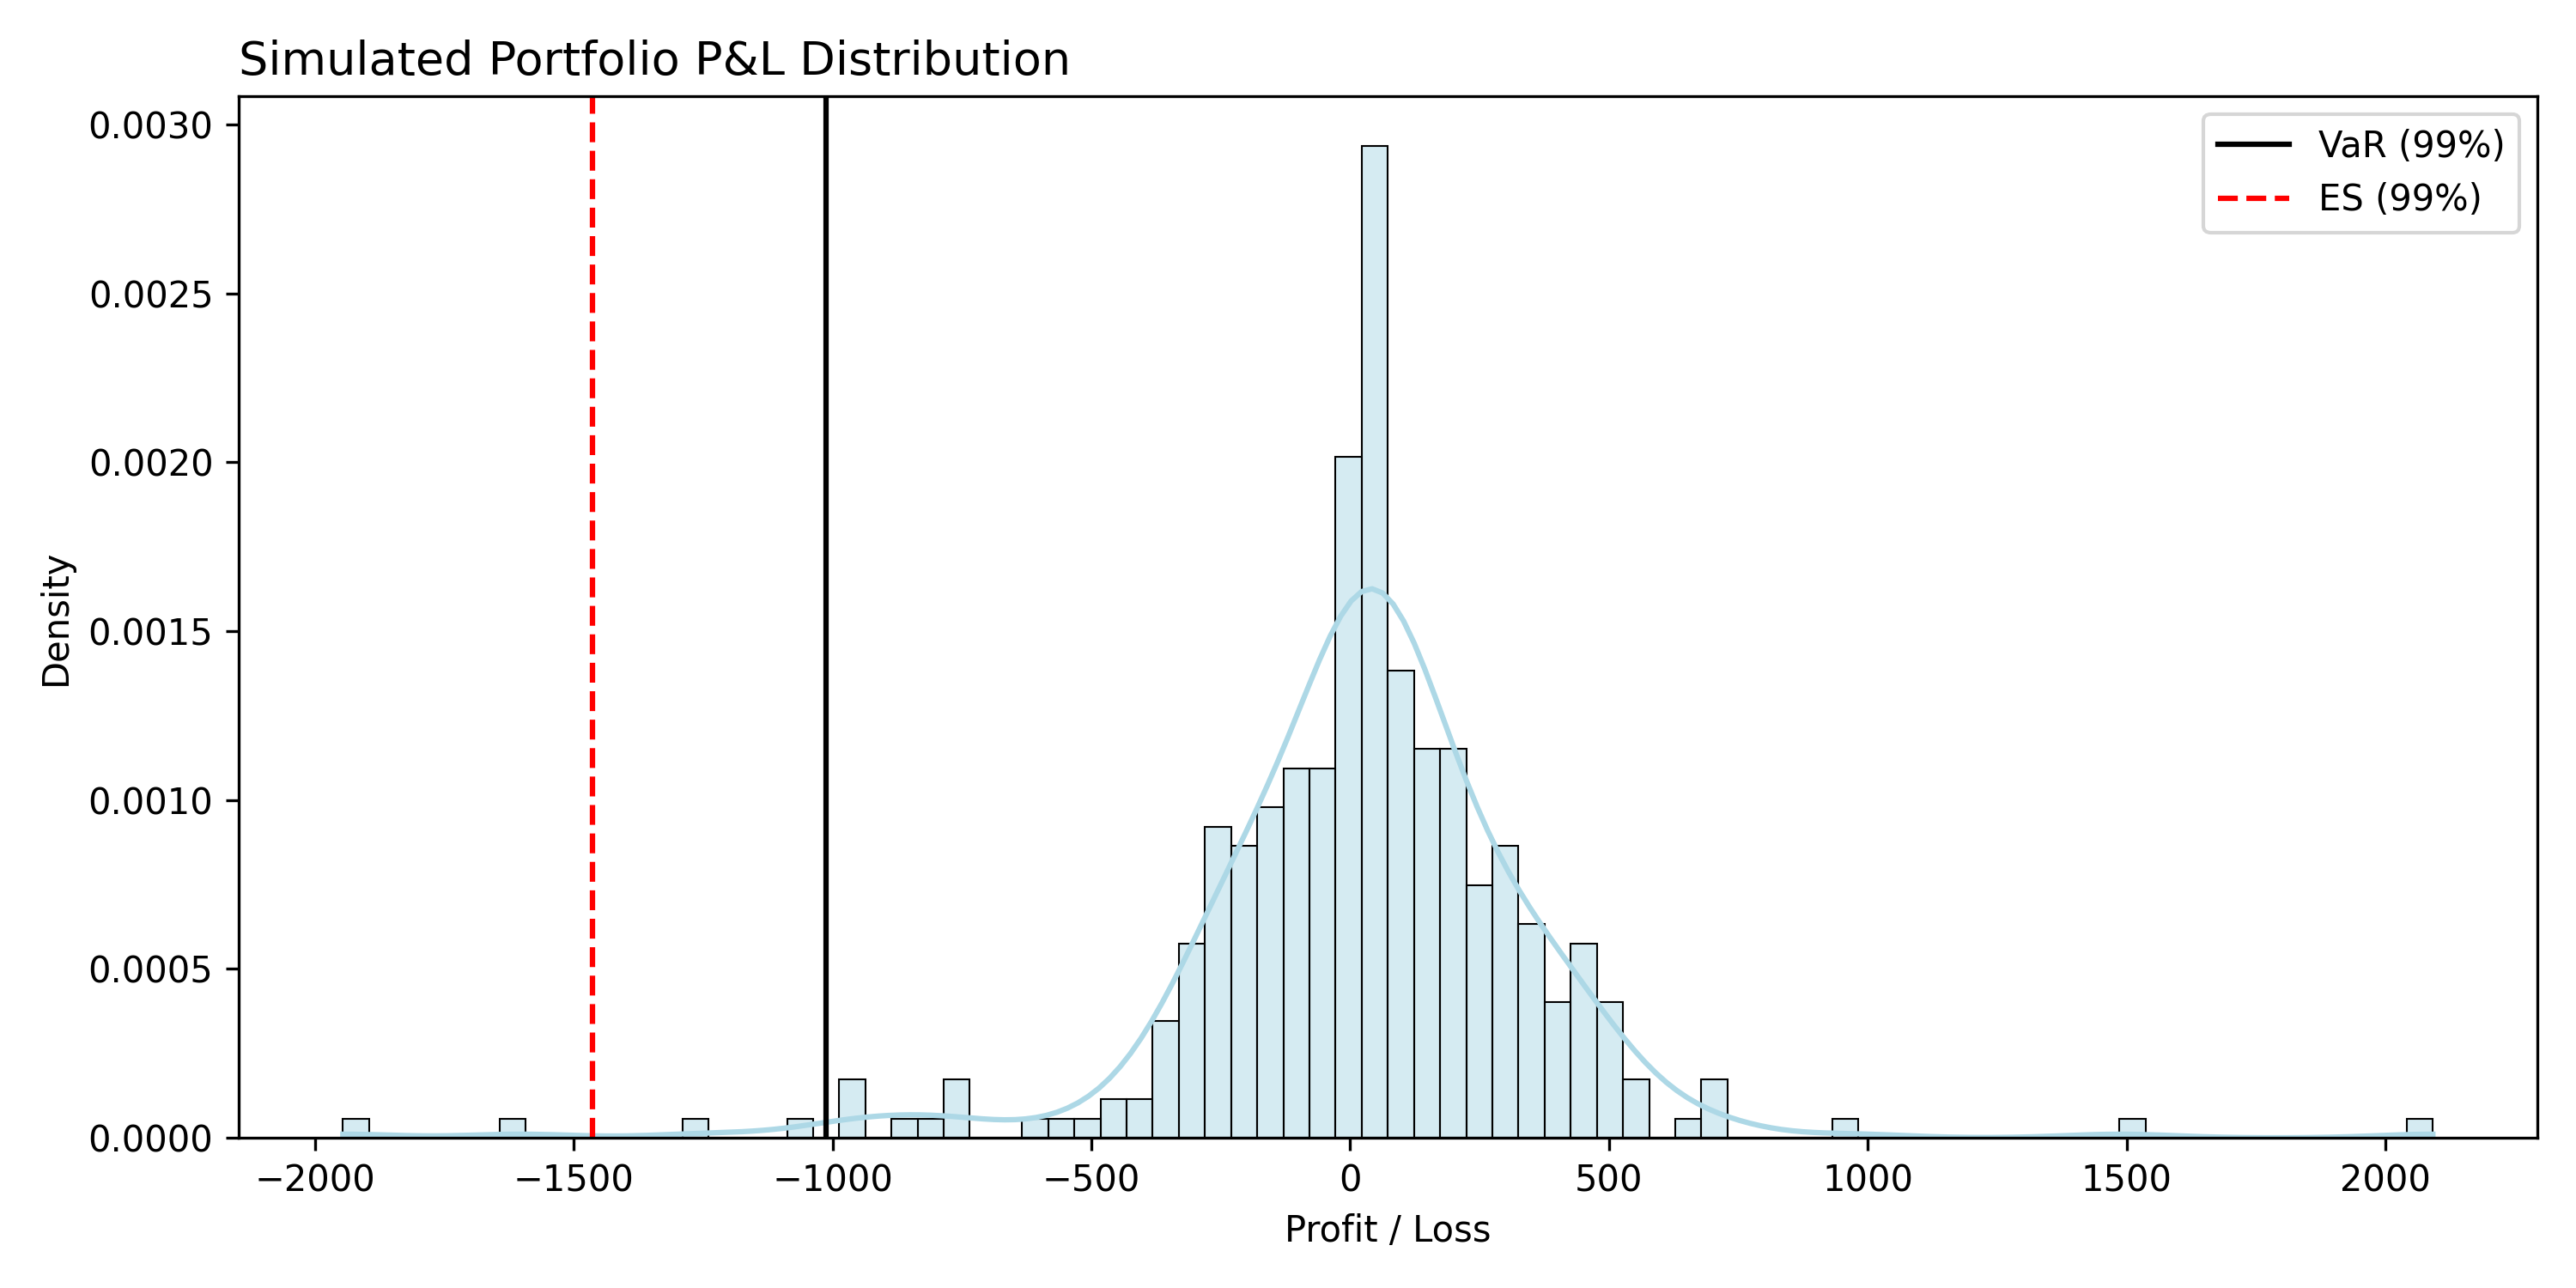

In [38]:
pt.plot_simulated_distribution(
    pnl=pnl_hist,
    var=var_hist,
    es=es_hist,
    confidence_level=0.99
)

In [39]:
# Run bootstrap simulation (1-day horizon, 99% confidence)
var_bootstrap, pnl_bootstrap = sim_2.historical_simulation_var(
    price_data=price_data_converted,
    shares=shares.values,
    options=options,
    confidence_level=0.99,
    bootstrap=True,
    simulations=10_000,
)

es_bootstrap = sim_2.simulation_es(var_bootstrap, pnl_bootstrap)

# Display results
print(f"Bootstrap VaR (99%):   {var_bootstrap:,.2f} CHF")
print(f"Bootstrap ES  (99%):   {es_bootstrap:,.2f} CHF")


Bootstrap VaR (99%):   950.68 CHF
Bootstrap ES  (99%):   1,328.07 CHF


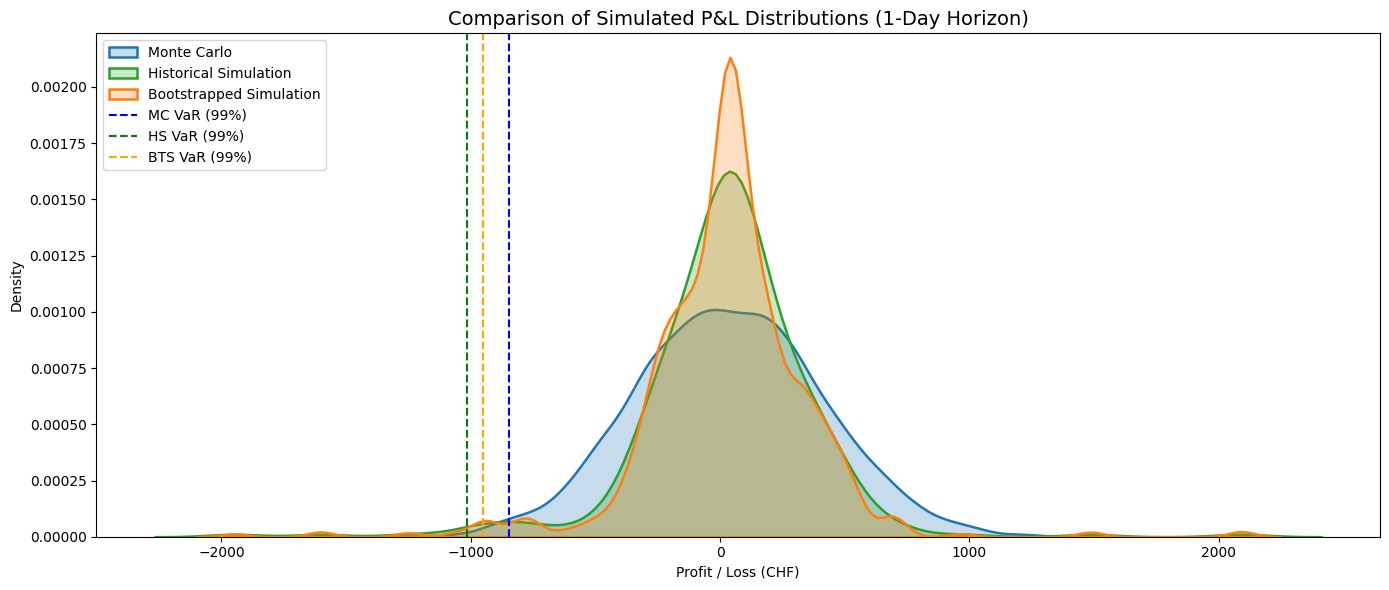

In [40]:
# Larger figure
plt.figure(figsize=(14, 6))

# KDE plots
sns.kdeplot(pnl_mc, label="Monte Carlo", fill=True, color="tab:blue", linewidth=1.8)
sns.kdeplot(pnl_hist, label="Historical Simulation", fill=True, color="tab:green", linewidth=1.8)
sns.kdeplot(pnl_bootstrap, label="Bootstrapped Simulation", fill=True, color="tab:orange", linewidth=1.8)

# VaR markers
plt.axvline(-var_mc, color="blue", linestyle="--", linewidth=1.5, label="MC VaR (99%)")
plt.axvline(-var_hist, color="green", linestyle="--", linewidth=1.5, label="HS VaR (99%)")
plt.axvline(-var_bootstrap, color="orange", linestyle="--", linewidth=1.5, label="BTS VaR (99%)")

# Final formatting
plt.title("Comparison of Simulated P&L Distributions (1-Day Horizon)", fontsize=14)
plt.xlabel("Profit / Loss (CHF)")
plt.ylabel("Density")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


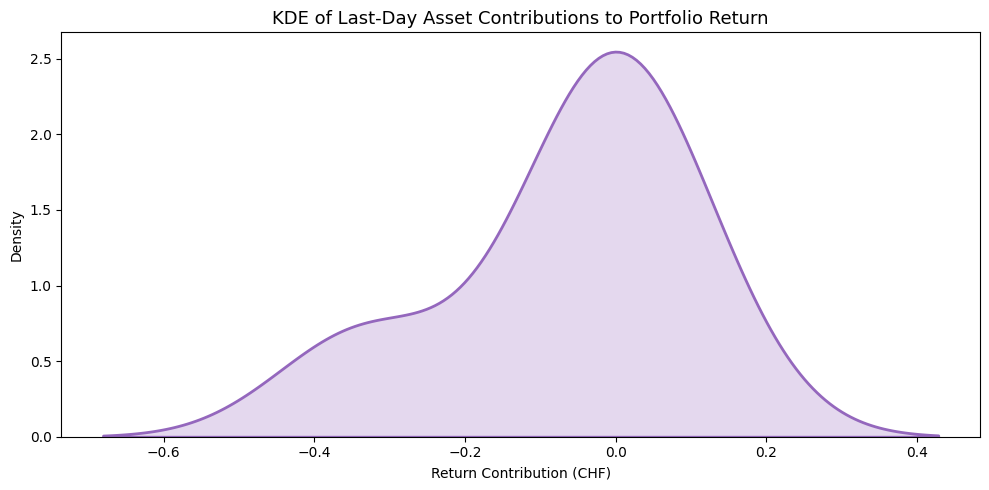

In [41]:
# Get the last row of asset returns
last_return_vector = returns.iloc[-1]  # pd.Series with index = tickers

# Multiply by shares to get contribution per asset
asset_contributions = last_return_vector.values * shares  # elementwise product

# Plot KDE of asset contributions
plt.figure(figsize=(10, 5))
sns.kdeplot(asset_contributions, fill=True, linewidth=2, color="tab:purple")
plt.title("KDE of Last-Day Asset Contributions to Portfolio Return", fontsize=13)
plt.xlabel("Return Contribution (CHF)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


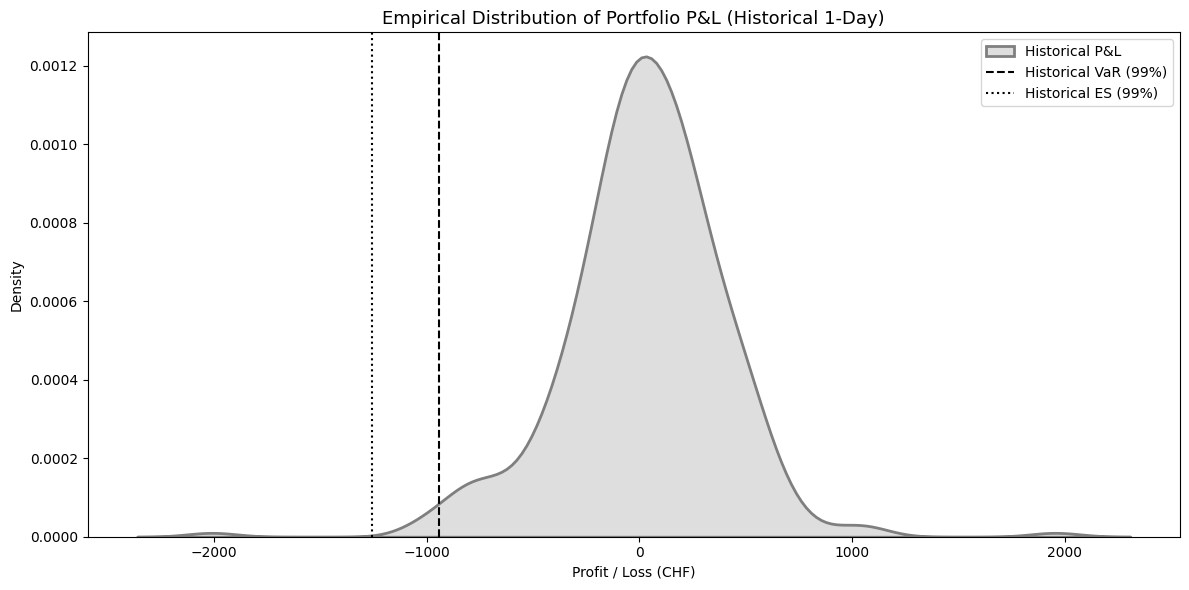

In [ ]:
# Compute daily portfolio value (equity only)
portfolio_values = (price_data * shares).sum(axis=1)

# Compute daily P&L in CHF
pnl_actual = portfolio_values.diff().dropna()

# Compute empirical VaR/ES at 99% confidence
alpha = 0.01
var_actual = -np.percentile(pnl_actual, alpha * 100)
es_actual = -pnl_actual[pnl_actual <= -var_actual].mean()

# Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(pnl_actual, fill=True, color="tab:gray", linewidth=2, label="Historical P&L")
plt.axvline(-var_actual, color="black", linestyle="--", linewidth=1.5, label="Historical VaR (99%)")
plt.axvline(-es_actual, color="black", linestyle=":", linewidth=1.5, label="Historical ES (99%)")
plt.title("Empirical Distribution of Portfolio P&L (Historical 1-Day)", fontsize=13)
plt.xlabel("Profit / Loss (CHF)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
